In [1]:

import tensorflow as tf
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [2]:
from tensorflow.keras.datasets import fashion_mnist

In [3]:
#load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


In [4]:
label_dict=["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

## 1. Prepare the data

Each input will include three `28*28*1` images in the following order: anchor image, positive image, negative image

Input into the model will be presented as `[vetor n*28*28*1,vector n*28*28*1,vector n*28*28*1]` => `3*n*28*28*1`

Output of the model will be presented as `[vector n*128, vector n*128, vector n*128]` => `3*n*128`

In [5]:

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

#fashion_mnist represent images as (28*28) matrix=> expand dim to (28*28*1)

train_images=np.expand_dims(train_images,axis=-1)
test_images=np.expand_dims(test_images,axis=-1)


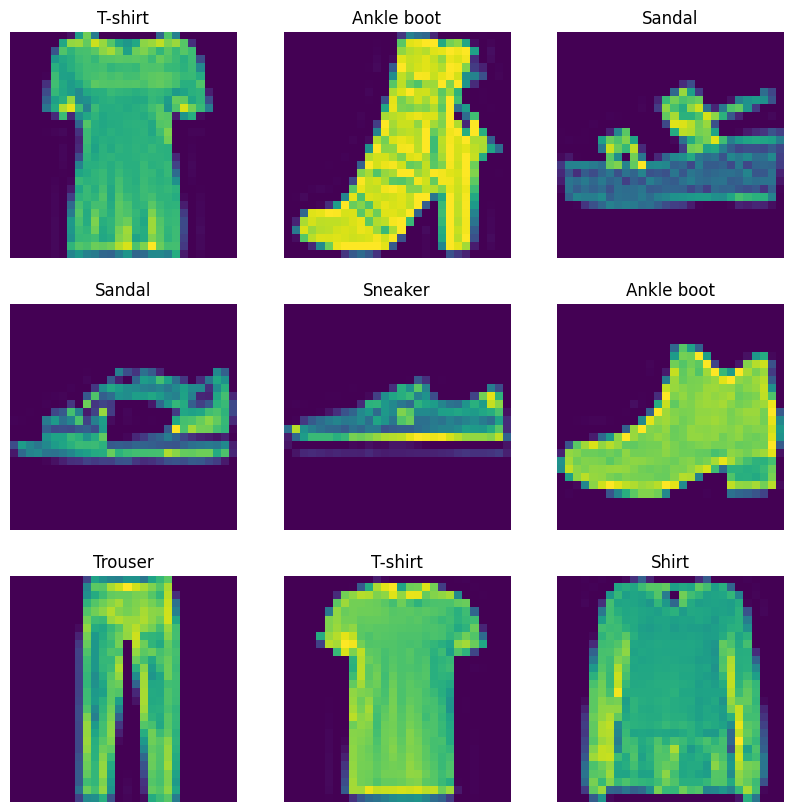

In [6]:
# explore the dataset
display_img=train_images[10:19]
display_label=train_labels[10:19]
plt.figure(figsize=(10, 10))
for i in range(len(display_label)):
    plt.subplot(3,3,i+1)
    plt.imshow(display_img[i])
    plt.title(label_dict[display_label[i]])
    plt.axis('off')
    
    


We will create the dataset we want by these following functions

In [7]:
def create_triples(x, digit_indices):
    '''Positive and negative triple creation.
    Each triple include two images of same label (anchor and postive) and one image of different label.
    '''
    triples = []
    labels = []
    
    # n is min length of an array of indices with a specific value (0->9)
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    #digit_indices[d]: contains all indices of images of the same label
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
           
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z3 = digit_indices[dn][i]
            triples += [[x[z1], x[z2],x[z3]]]
            labels += [1]
            
    return np.array(triples), np.array(labels)



def create_triples_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    triples, y = create_triples(images, digit_indices)
    y = y.astype('float32')
    
    return triples, y

In [8]:
train_x,train_y=create_triples_on_set(train_images,train_labels)
test_x,test_y=create_triples_on_set(test_images,test_labels)

In [9]:
# build a model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D,MaxPooling2D,Input, BatchNormalization

## 2. Build the model

#### 1. Build the base model

In [22]:
input_shape=(28,28,1)
inputs=Input(shape=input_shape)

x=Conv2D(5,(3,3),padding='valid',activation='relu')(inputs)
x=MaxPooling2D(pool_size=2,strides=1,padding='valid')(x)
x=BatchNormalization()(x)

x=Conv2D(10,(3,3),padding='valid',activation='relu')(x)
x=MaxPooling2D(pool_size=2,strides=1,padding='valid')(x)
x=BatchNormalization()(x)

x=Conv2D(20,(3,3),padding='valid',activation='relu')(x)
x=MaxPooling2D(pool_size=2,strides=2,padding='valid')(x)
x=BatchNormalization()(x)

x=Flatten()(x)
x=Dense(1024,activation='relu')(x)
x=Dropout(.2)(x)

x=Dense(512,activation='relu')(x)
x=Dropout(.2)(x)

x=Dense(256,activation='relu')(x)
x=Dropout(.2)(x)

x=Dense(128,activation='relu')(x)
x=Dropout(.2)(x)

outputs=Dense(128,activation='relu')(x)
base_model=Model(inputs=inputs,outputs=outputs)



In [23]:
base_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 5)         50        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 5)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 25, 25, 5)        20        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 23, 10)        460       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 10)       0   

#### 2. Build the siamese architect based on the base_model

In [24]:
#define the function to calculate the gap between the d(anchor,pos) and d(anchor,neg)
def triplet_loss_with_margin(y_pred,margin=0.2):
    
    """
     Implementation of the triplet loss as defined by formula (3)

        Arguments:
        y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
        y_pred -- python list containing three objects:
                anchor -- the encodings for the anchor images, of shape (None, 128)
                positive -- the encodings for the positive images, of shape (None, 128)
                negative -- the encodings for the negative images, of shape (None, 128)

    Returns:
    loss -- real number, value of the loss
    """
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.math.reduce_sum(tf.math.square(tf.math.subtract(anchor,positive)),axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.math.reduce_sum(tf.math.square(tf.math.subtract(anchor,negative)),axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.math.add(tf.math.subtract(pos_dist,neg_dist),margin)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.math.reduce_sum(tf.math.maximum(basic_loss,0.0))
    return loss
    
    

In [25]:
input_anchor=Input(shape=input_shape)
input_pos=Input(shape=input_shape)
input_neg=Input(shape=input_shape)
output_anchor=base_model(input_anchor)
output_pos=base_model(input_pos)
output_neg=base_model(input_neg)
output_loss=triplet_loss_with_margin([output_anchor,output_pos,output_neg],margin=0.2)
model=Model(inputs=[input_anchor,input_pos,input_neg],outputs=output_loss)

In [14]:
plot_model(model,show_shapes=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$

## 2. Build the loss

y_pred will have the shape of `3*n*128` => anchor, positive, negative will have shape of `n*128`

In [26]:
# define triplet loss
def identity_loss(y_true,y_pred):
    return K.mean(y_pred)

## 3. Training

In [27]:
base_learning_rate=0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=identity_loss)

#### 1. Before training, test the result

Before training, test the gap between (distance of anchor and pos) and (distance of achor and neg)

In [28]:
def display_test_set(test_set):
    #nchor, pos, neg = test_set[0], test_set[1], test_set[2]
    plt.figure(figsize=(10,3))
    labels=['anchor','postive','negative']
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.imshow(test_set[i])
        plt.title(labels[i])
        plt.axis('off')
    

In [29]:
#input will be 3 vector input of a test example
def triplet_test(test_set):


    anchor, pos, neg = test_set[0], test_set[1], test_set[2]
    
    anchor=np.expand_dims(test_set[0],axis=0)
    pos=np.expand_dims(test_set[1],axis=0)
    neg=np.expand_dims(test_set[2],axis=0)
    

    
    output_anchor=base_model.predict(anchor)
    output_pos=base_model.predict(pos)
    output_neg=base_model.predict(neg)
    
    
    pos_dis=np.sum(np.square(output_anchor-output_pos))
    neg_dis=np.sum(np.square(output_anchor-output_neg))

    print(pos_dis,neg_dis)
    display_test_set(test_set)

1/1 [==============================] - 0s 28ms/step
0.007879989 0.02370451


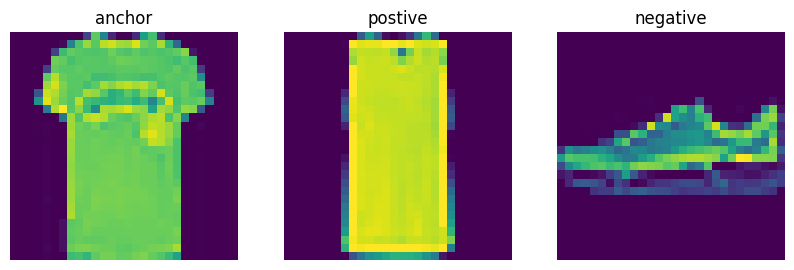

In [30]:
eval_x=test_x[0]
triplet_test(eval_x)

#### 2. We now start to train the model

In [31]:
 callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,verbose=1,restore_best_weights=True)

In [32]:
history=model.fit([train_x[:,0], train_x[:,1],train_x[:,2]], train_y, epochs=15, batch_size=256,callbacks=[callback] ,validation_data=([test_x[:,0], test_x[:,1],test_x[:,2]], test_y))

Epoch 1/15
235/235 [==============================] - 11s 38ms/step - loss: 54.5485 - val_loss: 12.0517
Epoch 2/15
235/235 [==============================] - 9s 37ms/step - loss: 14.0067 - val_loss: 9.3713
Epoch 3/15
235/235 [==============================] - 8s 36ms/step - loss: 10.5799 - val_loss: 8.1782
Epoch 4/15
235/235 [==============================] - 9s 37ms/step - loss: 8.8067 - val_loss: 7.0569
Epoch 5/15
235/235 [==============================] - 9s 37ms/step - loss: 7.3775 - val_loss: 6.6340
Epoch 6/15
235/235 [==============================] - 8s 36ms/step - loss: 6.3307 - val_loss: 6.0404
Epoch 7/15
235/235 [==============================] - 8s 35ms/step - loss: 5.7222 - val_loss: 5.9532
Epoch 8/15
235/235 [==============================] - 8s 35ms/step - loss: 4.9691 - val_loss: 5.8770
Epoch 9/15
235/235 [==============================] - 9s 38ms/step - loss: 4.6100 - val_loss: 5.5399
Epoch 10/15
235/235 [==============================] - 9s 37ms/step - loss: 4.3481 - v

In [36]:
base_model.save('final_model.h5')

In [39]:
base=tf.keras.models.load_model('final_model.h5')

1/1 [==============================] - 0s 31ms/step
0.3487047 1.1678793


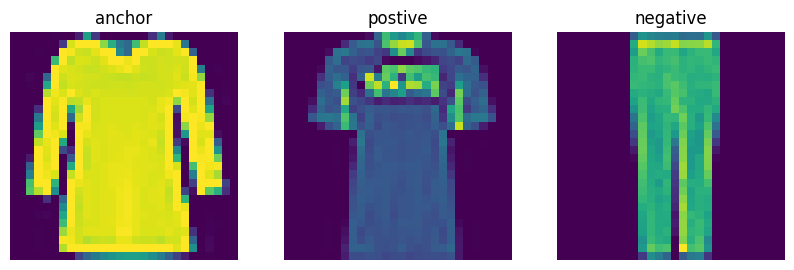

In [33]:
eval_x_after=test_x[12]
triplet_test(eval_x_after)

## 4. Conclusion

After just 15 epochs, we now have pretty good result. For the sake of convenience, we now do some extra steps.

In [34]:
#from train_images, single out 100 examples of each label

label_indices= [np.where(train_labels == i)[0] for i in range(10)]

In [35]:
for i in range(10):
    label_indices[i]=label_indices[i][:100]

In [25]:
img_set=np.zeros((10,100,28,28,1))
for i in range(10):
    for j in range(100):
        index=label_indices[i][j]
        img_set[i][j]=train_images[index]
    

In [32]:
encoding=np.zeros((10,128))
for i in range(10):
    hundred_example=base_model.predict(img_set[0])
    hundred_example=np.array(hundred_example)
    encoding[i]=np.mean(hundred_example,axis=0)

4/4 [==============================] - 0s 9ms/step


In [69]:
encoding[1]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.20321100e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.56558480e-03, 1.42163392e-02, 3.35855901e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.23409730e-01, 0.00000000e+00, 1.68049373e-02, 1.41579541e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.60975555e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

## 5. Test the model

Now we will test the model on real image from the test set to see how it work!

In [61]:
img=np.expand_dims(test_images[2],axis=0)
encoding_img=base_model.predict(img)

1/1 [==============================] - 0s 33ms/step


In [70]:
#we build a function to decide which encoding of 10 labels that our image is closest to

def closest_encoding(encode_img):
    min_value=100
    index=-1
    for i in range(10):
        if np.sum(np.square(encode_img-encoding[i]))<min_value:
            print(i)
            min_value=np.sum(np.square(encode_img-encoding[i]))
            index=i
    return min_value,index

In [71]:
min_dis,index=closest_encoding(encoding_img)

0


In [72]:
print(min_dis,index)

1.1668359979584322 0


In [74]:
test_labels[2]

1